# Model Creation for Toxicity Classifier

In [1]:
import os
import pandas as pd


using_colab = False

## Downloading Datasets from Kaggle

In [2]:
if using_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    # Check current location, '/content' is the Colab virtual machine
    print(os.getcwd())
    # Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
    os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/Kaggle'

    !kaggle datasets download -d ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
    !kaggle datasets download -d oswinrh/indonesian-stoplist

    !unzip 'indonesian-abusive-and-hate-speech-twitter-text.zip' -d 'abusive_text_dataset'
    !unzip 'indonesian-stoplist.zip' -d 'stoplist_dataset'

## Importing Datasets Using Pandas

note: abusive sentences is the training data

In [3]:
if using_colab:
    stopwords_path = '/content/stoplist_dataset/stopwordbahasa.csv'
    abusive_words_path = '/content/abusive_text_dataset/abusive.csv'
    alay_words_path = '/content/abusive_text_dataset/new_kamusalay.csv'
    abusive_sentences_path = '/content/abusive_text_dataset/data.csv'

if not using_colab:
    stopwords_path = './dataset/stopwordbahasa.csv'
    abusive_words_path = './dataset/abusive.csv'
    alay_words_path = './dataset/new_kamusalay.csv'
    abusive_sentences_path = './dataset/data.csv'

df_stopwords = pd.read_csv(stopwords_path, header=None)
df_stopwords = df_stopwords.rename(columns={0: 'stopword'})
df_abusive = pd.read_csv(abusive_words_path, encoding='latin-1')
df_alay = pd.read_csv(alay_words_path, encoding='latin-1', header=None)
df_alay = df_alay.rename(columns={0: 'original', 
                                  1: 'replacement'})
df_alay_map = dict(zip(df_alay['original'], df_alay['replacement']))
df_abusive_sentences = pd.read_csv(abusive_sentences_path, encoding='latin-1') 

### Checking the structure of each DataFrame




In [4]:
df_stopwords.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [5]:
df_abusive.head()

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing


In [6]:
df_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [7]:
df_abusive_sentences.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


### Checking if HS column corresponds with the HS_X columns

In [8]:
condition = df_abusive_sentences['HS'] != (df_abusive_sentences[df_abusive_sentences.columns[3:]].any(axis=1))
df_abusive_sentences[condition]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong


Therefore HS column is correct, HS will be 1 if any of HS_X columns contains 1

## Data Preprocessing

In [9]:
!pip install PySastrawi

In [10]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('\r',' ',text) # Remove every '\r'
    text = re.sub('(?i)rt',' ',text) # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]','',text) # Remove every username
    text = re.sub('(?i)user','',text) # Remove every username
    text = re.sub('(?i)url',' ',text) # Remove every url
    text = re.sub(r'\\x..',' ',text) # Remove every emoji
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Remove characters repeating more than twice

    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 

    return text

def normalize_alay(text):
    words = text.split(' ')
    normalized_words= []
    for word in words:
      if word in df_alay_map:
        normalized_words.append(df_alay_map[word])
      else:
        normalized_words.append(word)
      normalized_sentences = " ".join(normalized_words)
    return normalized_sentences

def remove_stopword(text):
    cleaned_words= []
    for word in text.split(' '):
      if word in df_stopwords['stopword'].values:
        cleaned_words.append('')
      else:
        cleaned_words.append(word)
      cleaned_sentences = ' '.join(cleaned_words)
    cleaned_sentences = re.sub('  +', ' ', cleaned_sentences) # Remove extra spaces
    cleaned_sentences = cleaned_sentences.strip()
    return cleaned_sentences

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = remove_unnecessary_char(text)
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_alay(text)
    text = remove_stopword(text)
    text = stemming(text)

    return text


In [11]:
df_abusive_sentences['Tweet'] = df_abusive_sentences['Tweet'].apply(preprocess)

## Text Vectorization

In [32]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices());
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()));

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8331148007688019465
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1833519662532580048
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [33]:
# Run if Tensorflow version < 2.0
# !pip install --upgrade tensorflow

In [34]:
from tensorflow.keras.layers import TextVectorization

In [35]:
x = df_abusive_sentences['Tweet']
y = df_abusive_sentences[['HS','Abusive']].values

In [36]:
max_features = 200000

In [37]:
vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(x.values)
vectorized_text = vectorizer(x.values)


In [38]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8) #adjust constants based on dataset

In [39]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Building the Model

In [40]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [41]:
model = tf.keras.models.Sequential()

model.add(Embedding(max_features+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh', )))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [47]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy', 'categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                      

### Training the Model

In [48]:
history = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
576/576 [==============================] - 84s 143ms/step - loss: 0.0680 - accuracy: 0.7657 - categorical_accuracy: 0.7657 - val_loss: 0.0541 - val_accuracy: 0.7854 - val_categorical_accuracy: 0.7854
Epoch 2/30
576/576 [==============================] - 81s 140ms/step - loss: 0.0616 - accuracy: 0.7826 - categorical_accuracy: 0.7826 - val_loss: 0.0466 - val_accuracy: 0.7687 - val_categorical_accuracy: 0.7687
Epoch 3/30
576/576 [==============================] - 81s 140ms/step - loss: 0.0567 - accuracy: 0.8151 - categorical_accuracy: 0.8151 - val_loss: 0.0446 - val_accuracy: 0.7797 - val_categorical_accuracy: 0.7797
Epoch 4/30
576/576 [==============================] - 81s 141ms/step - loss: 0.0531 - accuracy: 0.7788 - categorical_accuracy: 0.7788 - val_loss: 0.0481 - val_accuracy: 0.7649 - val_categorical_accuracy: 0.7649
Epoch 5/30
576/576 [==============================] - 83s 143ms/step - loss: 0.0462 - accuracy: 0.8054 - categorical_accuracy: 0.8054 - val_loss: 0.0387 - v

In [49]:
from matplotlib import pyplot as plt

<Figure size 1152x648 with 0 Axes>

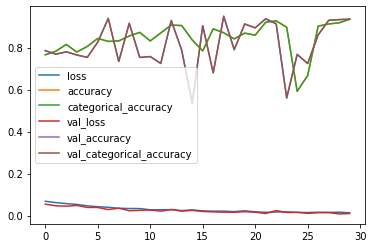

In [51]:
plt.figure(figsize=(16,9))
pd.DataFrame(history.history).plot()
plt.show()

# Testing the Model with User Inputs

In [52]:
input_text = vectorizer('bego lu')
res = model.predict(input_text)
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()

ValueError: in user code:

    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "bidirectional_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [53]:
(model.predict(batch_X) > 0.5).astype(int)
res.shape

NameError: name 'batch_X' is not defined

# Converting to TensorFlow Lite